<a href="https://colab.research.google.com/github/Pallabpal/Health-Insurance-Fraud-Detection/blob/main/Health_Insurance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import Libraries**

In [4]:
import numpy as np 
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.utils import resample
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.model_selection import StratifiedKFold 
from collections import Counter

from joblib import dump, load

import warnings
warnings.filterwarnings('ignore')

**Dataset loading**

In [5]:
dataset = pd.read_csv('Dataa.csv')

In [6]:
dataset.head(3)

,Area_Service,Hospital County,Hospital Id,Age,Gender,Cultural_group,ethnicity,Days_spend_hsptl,Admission_type,"Home or self care,",...,Mortality risk,Surg_Description,Weight_baby,Abortion,Emergency dept_yes/No,Tot_charg,Tot_cost,ratio_of_total_costs_to_total_charges,Result,Payment_Typology
0,Western NY,Allegany,37.0,30 to 49,F,White,Not Span/Hispanic,4,Elective,Home or Self Care,...,1,Medical,0,N,Y,5511.95,5582.49,1.012798,1,1
1,Western NY,Allegany,37.0,70 or Older,F,White,Not Span/Hispanic,4,Urgent,Short-term Hospital,...,2,Medical,0,N,Y,4783.20,5162.82,1.079365,1,1
2,Western NY,Allegany,37.0,30 to 49,F,White,Not Span/Hispanic,3,Urgent,Home or Self Care,...,1,Medical,0,N,Y,3829.15,4056.52,1.059379,1,1


In [7]:
dataset.columns

Index(['Area_Service', 'Hospital County', 'Hospital Id', 'Age', 'Gender',
       'Cultural_group', 'ethnicity', 'Days_spend_hsptl', 'Admission_type',
       'Home or self care,', 'ccs_diagnosis_code', 'ccs_procedure_code',
       'apr_drg_description', 'Code_illness', 'Mortality risk',
       'Surg_Description', 'Weight_baby', 'Abortion', 'Emergency dept_yes/No',
       'Tot_charg', 'Tot_cost', 'ratio_of_total_costs_to_total_charges',
       'Result', 'Payment_Typology'],
      dtype='object')

**removing spaces in dataset column names**

In [8]:
dataset.columns = dataset.columns.to_series().apply(lambda x: x.replace(' ', '_')).to_list()
dataset.columns = dataset.columns.to_series().apply(lambda x: x.replace('/', '_')).to_list()
dataset.columns.values

array(['Area_Service', 'Hospital_County', 'Hospital_Id', 'Age', 'Gender',
       'Cultural_group', 'ethnicity', 'Days_spend_hsptl',
       'Admission_type', 'Home_or_self_care,', 'ccs_diagnosis_code',
       'ccs_procedure_code', 'apr_drg_description', 'Code_illness',
       'Mortality_risk', 'Surg_Description', 'Weight_baby', 'Abortion',
       'Emergency_dept_yes_No', 'Tot_charg', 'Tot_cost',
       'ratio_of_total_costs_to_total_charges', 'Result',
       'Payment_Typology'], dtype=object)

In [9]:
dataset.rename(columns={'Home_or_self_care,': 'Home_or_self_care'}, inplace=True)

In [10]:
data= pd.read_csv('Dataa.csv')
data_sample_view = data.head(2)

**For deployment part, sample dataframe view**

In [11]:
dump(data_sample_view, 'data_sample_view.joblib')

['data_sample_view.joblib']

In [12]:
dataset.shape

(3237, 24)

In [13]:
dataset.drop_duplicates(inplace=True)
dataset.dropna(inplace=True)
dataset.shape

(3212, 24)

In [14]:
dataset.select_dtypes(include=['object']).head(2)

,Area_Service,Hospital_County,Age,Gender,Cultural_group,ethnicity,Admission_type,Home_or_self_care,apr_drg_description,Surg_Description,Abortion,Emergency_dept_yes_No
0,Western NY,Allegany,30 to 49,F,White,Not Span/Hispanic,Elective,Home or Self Care,Other pneumonia,Medical,N,Y
1,Western NY,Allegany,70 or Older,F,White,Not Span/Hispanic,Urgent,Short-term Hospital,Cellulitis & other skin infections,Medical,N,Y


**Trying to convert string formatted data to integer / find out which value is not getting converted to integer datatype**

In [15]:
for i in dataset.Days_spend_hsptl.unique():
    try:
        int(i)
    except ValueError:
        print(i)

In [16]:
dataset.Days_spend_hsptl = dataset.Days_spend_hsptl.astype('int')
dataset.Hospital_Id = dataset.Hospital_Id.astype('int')
dataset.Mortality_risk = dataset.Mortality_risk.astype('int')

**Dropping non important Columns**

In [17]:
dataset.drop(['Hospital_Id', 'apr_drg_description', 'Abortion', 'Weight_baby'], axis=1, inplace=True)

**Encoding**

In [18]:
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
label = LabelEncoder()
label_binizer =LabelBinarizer()

In [19]:
label_area = label.fit(dataset.Area_Service)
label_Hospital_County = label.fit(dataset.Hospital_County)
label_Age = label.fit(dataset.Age)
label_Cultural_group = label.fit(dataset.Cultural_group)
label_ethnicity= label.fit(dataset.ethnicity)
label_Admission_type = label.fit(dataset.Admission_type)
label_Home_or_self_care = label.fit(dataset.Home_or_self_care)
one_hot_Gender = label_binizer.fit(dataset.Gender)
one_hot_Surg_Description = label_binizer.fit(dataset.Surg_Description)
one_hot_Emergency_dept_yes_No = label_binizer.fit(dataset.Emergency_dept_yes_No)

In [20]:
label_encoder_list = [label_area, label_Hospital_County,
                label_Age, label_Cultural_group,
                label_ethnicity, label_Admission_type,
                label_Home_or_self_care]

one_hot_coder_list = [one_hot_Gender, one_hot_Surg_Description, one_hot_Emergency_dept_yes_No]

**Pickling encoding object & columns for deployment point of view**

In [21]:
from joblib import dump, load

In [22]:
dump(label_encoder_list, 'label_encoder_list.joblib')
dump(one_hot_coder_list, 'one_hot_coder_list.joblib')

['one_hot_coder_list.joblib']

In [23]:
label_to_column = ['Area_Service', 'Hospital_County',
                  'Age', 'Cultural_group', 'ethnicity',
                  'Admission_type', 'Home_or_self_care']

In [24]:
one_hot_column = ['Gender', 'Surg_Description', 'Emergency_dept_yes_No']

In [25]:
dump(label_to_column, 'label_to_column.joblib')

['label_to_column.joblib']

In [26]:
dump(one_hot_column, 'one_hot_column.joblib')

['one_hot_column.joblib']

**Applyibng label encoding on columns..also this below cells can be used in deployment as well**

In [27]:
j = 0
for i in label_to_column:
    dataset[i] = label_encoder_list[j].fit_transform(dataset[i])
    j =+1

**applyibng one hot encoding on columns..also this below cells can be used in deployment as well**

In [28]:
k = 0
for i in one_hot_column:
    dataset[i] = one_hot_coder_list[k].fit_transform(dataset[i])
    k =+1

**Performing on sample datasets**

In [35]:
sample_data = dataset.sample(frac=0.1)

In [36]:
sample_data.Result.value_counts()

1    234
0     87
Name: Result, dtype: int64

**Upsampling before splitting the data into train & test**

In [39]:
sample_minority = sample_data.loc[sample_data['Result']==0]
sample_majority = sample_data.loc[sample_data['Result']==1]


In [40]:
from sklearn.utils import resample
sample_data_minority_upsampled = resample(sample_minority , replace=True, n_samples=12000, random_state=42)

In [41]:
sample_data_upsampled = pd.concat([sample_majority, sample_data_minority_upsampled ], ignore_index=True)

In [42]:
x = sample_data_upsampled.drop(['Result'],axis=1).values
y = sample_data_upsampled.Result.values

In [46]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, stratify = y, random_state=42)

In [47]:
def find_alpha(x_train, x_test, y_train, y_test):
    
    import matplotlib.pyplot as plt
    from sklearn.ensemble import RandomForestClassifier
    
    
    ccp_alphas = np.arange(0.000, 0.040, 0.002)
    clfs = []
    for ccp_alpha in ccp_alphas:
        clf = RandomForestClassifier(n_estimators=15, random_state=42, ccp_alpha=ccp_alpha)
        clf.fit(x_train, y_train)
        clfs.append(clf)

    train_scores = [clf.score(x_train, y_train) for clf in clfs]
    test_scores = [clf.score(x_test, y_test) for clf in clfs]

    fig, ax = plt.subplots(figsize=(15,6))
    ax.set_xlabel("alpha")
    ax.set_ylabel("accuracy")
    ax.set_title("Accuracy vs alpha for training and testing sets")
    ax.plot(ccp_alphas, train_scores, marker='o', label="train",drawstyle="steps-post")
    ax.plot(ccp_alphas, test_scores, marker='o', label="test",drawstyle="steps-post")
    ax.set_xticks(np.arange(0.000,0.040, 0.002))
    ax.set_yticks(np.arange(0.70,1.01, 0.1))
    ax.legend()
    plt.grid(True)
    plt.rcParams['xtick.labelsize']=12
    plt.rcParams['ytick.labelsize']=12
    plt.show()

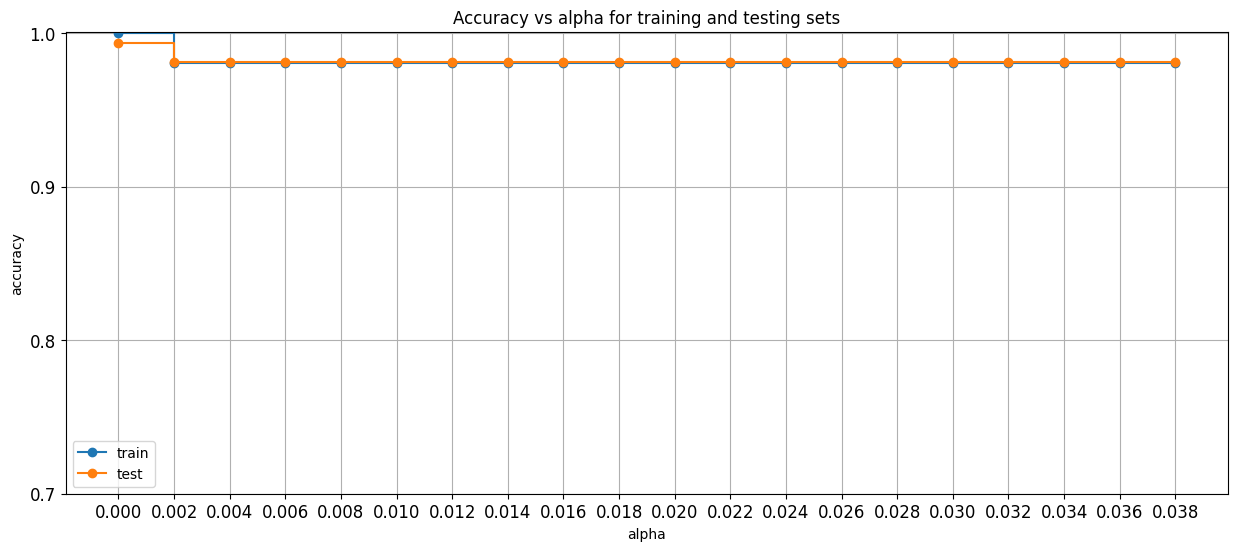

In [48]:
find_alpha(x_train, x_test, y_train, y_test)

**Building Model with n_estimators=100**

In [49]:
from sklearn.ensemble import RandomForestClassifier
sample_RF_upsampled = RandomForestClassifier(n_estimators=100, random_state=42)

In [50]:
clf_sample = sample_RF_upsampled.fit(x_train, y_train)

In [52]:
y_pred_train = clf_sample.predict(x_train)
y_pred = clf_sample.predict(x_test)

In [53]:
print(classification_report(y_train, y_pred_train ))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8399
           1       1.00      1.00      1.00       164

    accuracy                           1.00      8563
   macro avg       1.00      1.00      1.00      8563
weighted avg       1.00      1.00      1.00      8563



In [54]:
print(classification_report(y_test, y_pred ))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      3601
           1       1.00      0.67      0.80        70

    accuracy                           0.99      3671
   macro avg       1.00      0.84      0.90      3671
weighted avg       0.99      0.99      0.99      3671



**Building Model with n_estimators=15**

In [58]:
from sklearn.ensemble import RandomForestClassifier
sample_RF15_upsampled = RandomForestClassifier(n_estimators=15, random_state=42)

In [55]:
cross_val_score(clf_sample, x, y)

array([0.99346138, 0.99346138, 0.99264405, 0.99264405, 0.99427637])

In [59]:
clf_15_sample = sample_RF_upsampled.fit(x_train, y_train)

In [60]:
y_pred_train = clf_15_sample.predict(x_train)
y_pred = clf_15_sample.predict(x_test)

In [61]:
print(classification_report(y_train, y_pred_train ))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8399
           1       1.00      1.00      1.00       164

    accuracy                           1.00      8563
   macro avg       1.00      1.00      1.00      8563
weighted avg       1.00      1.00      1.00      8563



In [62]:
print(classification_report(y_test, y_pred ))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      3601
           1       1.00      0.67      0.80        70

    accuracy                           0.99      3671
   macro avg       1.00      0.84      0.90      3671
weighted avg       0.99      0.99      0.99      3671

